# Setup
Import dependecies and dataset

In [32]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from keras import layers
from keras import models
from keras import metrics
from keras import activations
from keras import optimizers

from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing

from imblearn import over_sampling
from imblearn import under_sampling


recipes = pd.read_csv('recipes/recipes.csv')

# Preprocessing Steps
Changes cells representations from words to integers

In [33]:
def word2int(elem):
    if elem == 'No':
        return 0
    elif elem == 'Yes':
        return 1
    else: return elem
    
recipes = recipes.applymap(word2int)

### Eliminates redundant labels

In [35]:
recipes['country'].replace(to_replace='Italian', value='Italy', inplace=True)
recipes['country'].replace(to_replace='italian', value='Italy', inplace=True)
    
recipes['country'].replace(to_replace='French', value='France', inplace=True)
recipes['country'].replace(to_replace='German', value='Germany', inplace=True)  

recipes['country'].replace(to_replace='mexico', value='Mexico', inplace=True)
recipes['country'].replace(to_replace='asian', value='Asian', inplace=True)

recipes['country'].replace(to_replace='Chinese', value='China', inplace=True)
recipes['country'].replace(to_replace='chinese', value='China', inplace=True) 

recipes['country'].replace(to_replace='korean', value='Korea', inplace=True)
recipes['country'].replace(to_replace='Thai', value='Thailand', inplace=True)   

recipes['country'].replace(to_replace='Japanese', value='Japan', inplace=True)
recipes['country'].replace(to_replace='japanese', value='Japan', inplace=True) 

recipes['country'].replace(to_replace='Indian', value='India', inplace=True)
recipes['country'].replace(to_replace='Vietnamese', value='Vietnam', inplace=True)  
recipes['country'].replace(to_replace='Scandinavian', value='Scandinavia', inplace=True)

### Split into labels and features

In [37]:
y = recipes['country']

X = recipes.drop(columns=['country'])

### Plot histogram of classes

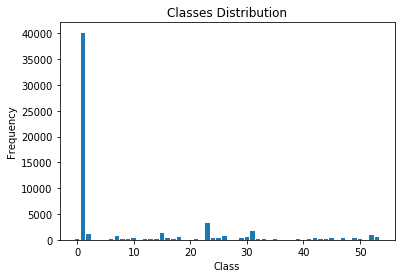

In [38]:
nclasses = len(set(y))

y_plot = y.astype('category')
y_plot = y_plot.cat.codes

y_hist = np.empty(nclasses)

for i in range(nclasses):
    y_hist[i] = len(y_plot[y_plot==i])

    
fig, ax = plt.subplots()

ax.set_xlabel('Class')
ax.set_title('Classes Distribution')
ax.set_ylabel('Frequency')

plot = plt.bar(range(nclasses), y_hist)
plt.show()

### Split into train, test and validation sets

In [39]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,
                                                                    random_state=123, stratify=y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2,
                                                                  random_state=123, stratify=y_train)

### Eliminate some examples of the marjority class

In [40]:
X_train['country'] = y_train

indexNames = X_train[X_train['country'] == 'American'].index 
rows2drop =indexNames[:-1000]

X_train.drop(rows2drop, inplace=True)

indexNames = X_train[X_train['country'] == 'Italy'].index 
rows2drop =indexNames[:-1000]

X_train.drop(rows2drop, inplace=True)

indexNames = X_train[X_train['country'] == 'Mexico'].index 
rows2drop =indexNames[:-1000]

X_train.drop(rows2drop, inplace=True)


y_train = X_train['country']

X_train = X_train.drop(columns=['country'])

y_train = y_train.values
X_train = X_train.values

### Plot histogram of classes after resampling

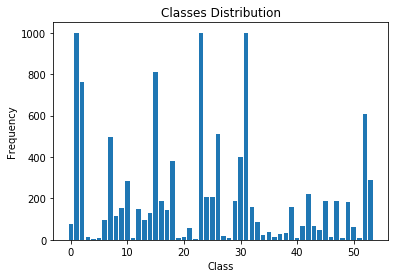

In [41]:
nclasses = len(set(y))

y_plot = pd.Series(y_train)
y_plot = y_plot.astype('category')
y_plot = y_plot.cat.codes

y_hist = np.empty(nclasses)

for i in range(nclasses):
    y_hist[i] = len(y_plot[y_plot==i])

    
fig, ax = plt.subplots()

ax.set_xlabel('Class')
ax.set_title('Classes Distribution')
ax.set_ylabel('Frequency')

plot = plt.bar(range(nclasses), y_hist)
plt.show()

### One hot encoding labels
Transform labels from categorical to one-hot-encoded 

In [42]:
def one_hot_function(labels):
    countries = list(set(labels))

    one_hot_labels = np.zeros(shape=(labels.size, len(countries)))
    
    rows_it = range(labels.size)
    columns_it = range(len(countries))
    
    for row in rows_it:
        for column in columns_it:
            if labels[row] == countries[column]:
                one_hot_labels[row, column] = 1
            
    return pd.DataFrame(data=one_hot_labels, columns=countries)   


y_train = one_hot_function(y_train)
y_val = one_hot_function(y_val.values)
y_test = one_hot_function(y_test.values)
print(list(y_train))

['Bangladesh', 'Southwestern', 'UK-and-Ireland', 'Malaysia', 'western', 'Turkey', 'Spain', 'Japan', 'Thailand', 'Philippines', 'east_asian', 'Israel', 'Central_SouthAmerican', 'Pakistan', 'Mexico', 'Eastern-Europe', 'Austria', 'China', 'EasternEuropean_Russian', 'Mexican', 'Moroccan', 'Vietnam', 'France', 'South-America', 'Cajun_Creole', 'American', 'Spanish_Portuguese', 'Asian', 'Mediterranean', 'Scandinavia', 'South-African', 'African', 'Irish', 'Portugal', 'Lebanon', 'Caribbean', 'Italy', 'Korea', 'North-African', 'Switzerland', 'Belgium', 'MiddleEastern', 'Southern_SoulFood', 'Netherlands', 'India', 'West-African', 'Germany', 'Canada', 'East-African', 'Greek', 'English_Scottish', 'Indonesia', 'Iran', 'Jewish']


# Build the Neural Network structure
Using Keras

In [43]:
nn_input = layers.Input(shape=(383,))

layer = layers.Dense(400, activation='relu')(nn_input)
layer = layers.Dense(400, activation='relu')(layer)
layer = layers.Dense(400, activation='relu')(layer)
layer = layers.Dropout(0.5)(layer)
output = layers.Dense(nclasses, activation='softmax')(layer)


model = models.Model(nn_input, output)

my_optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

model.compile(optimizer=my_optimizer,
              loss='mean_absolute_error',
              metrics=['accuracy'])


# Train the Neural Network

In [44]:
model.fit(x=X_train, y=y_train,
          epochs=100,
          batch_size=200,
          shuffle=True,
          validation_data=(X_val, y_val))

Train on 11014 samples, validate on 9231 samples
Epoch 1/50
11014/11014 [==============================] - 1s 128us/step - loss: 0.0338 - acc: 0.0900 - val_loss: 0.0113 - val_acc: 0.6959
Epoch 2/50
11014/11014 [==============================] - 1s 97us/step - loss: 0.0337 - acc: 0.0908 - val_loss: 0.0120 - val_acc: 0.6859
Epoch 3/50
11014/11014 [==============================] - 1s 97us/step - loss: 0.0317 - acc: 0.1437 - val_loss: 0.0135 - val_acc: 0.6361
Epoch 4/50
11014/11014 [==============================] - 1s 99us/step - loss: 0.0315 - acc: 0.1504 - val_loss: 0.0345 - val_acc: 0.0139
Epoch 5/50
11014/11014 [==============================] - 1s 99us/step - loss: 0.0304 - acc: 0.1796 - val_loss: 0.0133 - val_acc: 0.6453
Epoch 6/50
11014/11014 [==============================] - 1s 111us/step - loss: 0.0298 - acc: 0.1957 - val_loss: 0.0115 - val_acc: 0.6908
Epoch 7/50
11014/11014 [==============================] - 1s 104us/step - loss: 0.0297 - acc: 0.1990 - val_loss: 0.0125 - val_a

# Compute predictions
Change predictions vector representation from probabilities to one-hot-encoded 

In [45]:
def prob2sparse(y):
    
    shape = y.shape
    row_it = range(shape[0])
    column_it = range(shape[1])
    
    biggest = np.amax(y, axis=1)

    for row in row_it:
        for column in column_it:
            if y[row, column]<biggest[row]:
                y[row,column] = 0
            elif y[row, column]==biggest[row]:
                y[row,column] = 1
                
    return y


y_pred = model.predict(X_test)
y_pred = prob2sparse(y_pred)

y_pred = pd.DataFrame(data=y_pred, columns=list(y_train))   

# Evaluation Metrics

Multiclass F1 score on test set: 0.4578386341970708
Logistic loss on test set: 18.72559018494176
Accuracy on test set: 0.4578386341970708


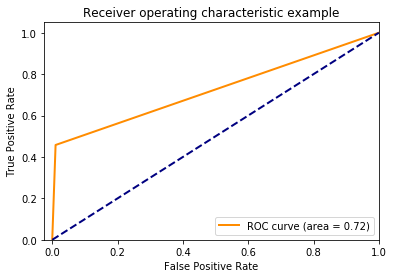

In [50]:
print("Multiclass F1 score on test set:", metrics.f1_score(y_test, y_pred, average='micro'))
print("Logistic loss on test set:", metrics.log_loss(y_test, y_pred))
print("Accuracy on test set:",metrics.accuracy_score(y_test, y_pred))

y_test_plot = y_test.values
y_pred_plot = y_pred.values

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(54):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_plot[:, i], y_pred_plot[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_plot.ravel(), y_pred_plot.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, linestyle='-',
         label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()